SUBJECT 5 : A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise


In [ ]:
!pip install numpy==1.23.5
!pip install pyclustering

  Using cached pyclustering-0.10.1.2-py3-none-any.whl


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles
import numpy as np
from google.colab import drive
from sklearn.cluster import DBSCAN
from pyclustering.cluster.clarans import clarans
from pyclustering.utils import read_sample
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.metrics import pairwise_distances_argmin
import time

drive.mount('/content/drive')

# Download the zip file at https://prd-tnm.s3.amazonaws.com/index.html?prefix=StagedProducts/GeographicNames/DomesticNames/
# Extract the txt file to get Sequoia 2000 benchmark dataset

file_path = "/content/drive/MyDrive/Colab Notebooks/StatLearn/DomesticNames_CA.txt"
dataCA = pd.read_csv(file_path, sep='|', header=0)
print(dataCA.shape)

Mounted at /content/drive
(52676, 21)


Generation of the 3 types of synthetic data

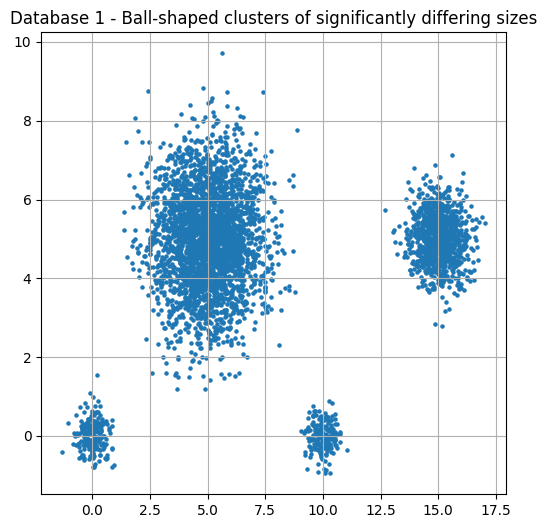

In [ ]:
def generate_sample_database_1():
    centers = [[0, 0], [5, 5], [10, 0], [15, 5]]
    cluster_std = [0.4, 1.2, 0.35, 0.6]  # différentes densités
    X, _ = make_blobs(n_samples=[200, 3000, 200, 1000], centers=centers, cluster_std=cluster_std, random_state=42)
    return X

data1 = generate_sample_database_1()

# Visualisation
plt.figure(figsize=(6, 6))
plt.scatter(data1[:, 0], data1[:, 1], s=5)
plt.title("Database 1 - Ball-shaped clusters of significantly differing sizes")
plt.grid(True)
plt.show()

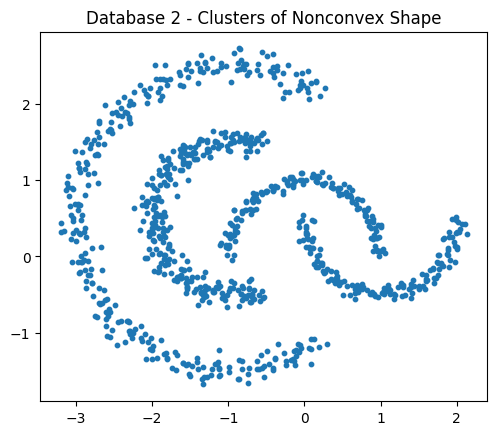

In [ ]:
def generate_sample_database_2():
    # Générer des demi-lunes (non convexe)
    X_moons, _ = make_moons(n_samples=300, noise=0.05, random_state=42)

    X_circles, _ = make_circles(n_samples=900, noise=0.05, factor=0.5, random_state=42)
    X_circles = X_circles[X_circles[:, 0] < X_circles[:, 1]**2]
    X_circles[:,:] *= 2
    X_circles[:,0] -= 1
    X_circles[:,1] += 0.5

    return np.vstack([X_moons, X_circles])

data2 = generate_sample_database_2()

# Afficher
plt.scatter(data2[:, 0], data2[:, 1], s=10)
plt.title("Database 2 - Clusters of Nonconvex Shape")
plt.gca().set_aspect('equal')  # Pour éviter la déformation
plt.show()

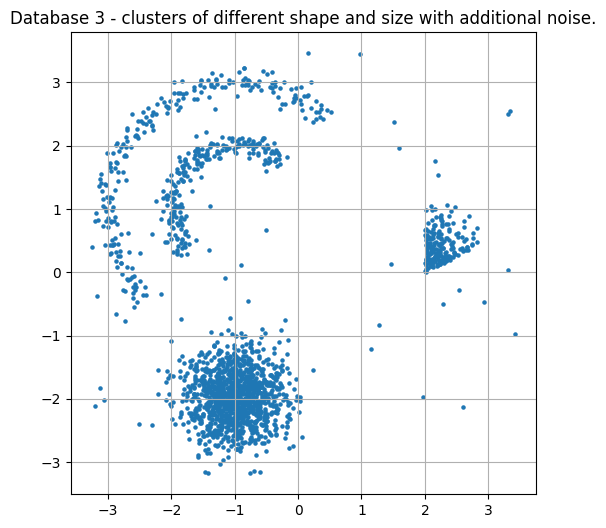

In [ ]:
def generate_sample_database_3():
    X_ball1, _ = make_blobs(n_samples=1000, centers=[[2, 0]], cluster_std=0.4, random_state=42)
    X_ball1 = X_ball1[X_ball1[:, 0] > 2]
    X_ball1 = X_ball1[X_ball1[:, 0] -2 < 2 * X_ball1[:, 1]]

    X_ball2, _ = make_blobs(n_samples=1200, centers=[[-1, -2]], cluster_std=0.4, random_state=42)


    X_circles, _ = make_circles(n_samples=900, noise=0.05, factor=0.5, random_state=42)
    X_circles = X_circles[X_circles[:, 0] < X_circles[:, 1]]
    X_circles[:,:] *= 2
    X_circles[:,0] -= 1
    X_circles[:,1] += 1
    noise = np.random.uniform(low=-3.5, high=3.5, size=(50, 2))  # bruit
    return np.vstack([X_ball1, X_ball2, X_circles, noise])

data3 = generate_sample_database_3()

# Visualisation
plt.figure(figsize=(6, 6))
plt.scatter(data3[:, 0], data3[:, 1], s=5)
plt.title("Database 3 - clusters of different shape and size with additional noise.")
plt.grid(True)
plt.show()


Visualization of the real dataset (map of California)

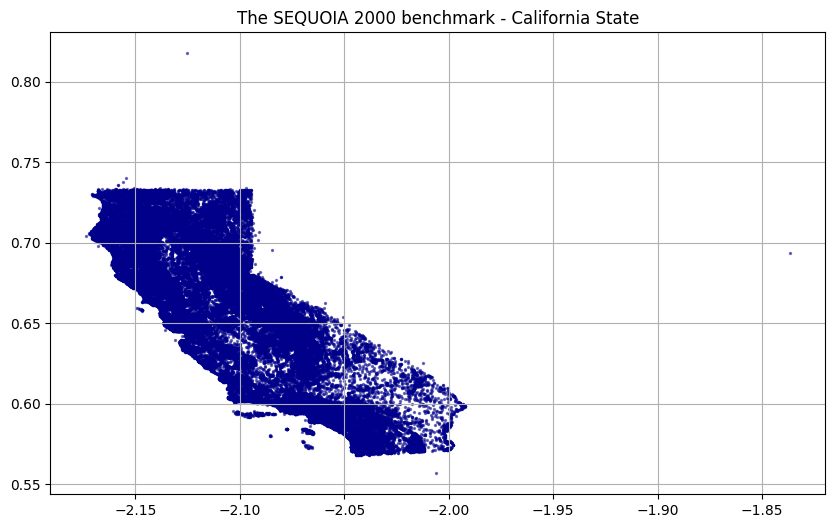

In [ ]:
# Extraire les coordonnées valides
data4 = dataCA[['prim_long_dec', 'prim_lat_dec']].copy()
data4 = data4.dropna()  # supprimer les lignes avec valeurs manquantes

# Les sous datasets sont créés tant qu'on est avec des dataframes
data4_5 = data4.sample(frac=0.05, random_state=42)
data4_10 = data4.sample(frac=0.10, random_state=42)
data4_15 = data4.sample(frac=0.15, random_state=42)
data4_20 = data4.sample(frac=0.20, random_state=42)

data4 = data4.to_numpy()
data4 = np.radians(data4)

data4_5 = data4_5.to_numpy()
data4_5 = np.radians(data4_5)

data4_10 = data4_10.to_numpy()
data4_10 = np.radians(data4_10)

data4_15 = data4_15.to_numpy()
data4_15 = np.radians(data4_15)

data4_20 = data4_20.to_numpy()
data4_20 = np.radians(data4_20)

# 2. Affichage
plt.figure(figsize=(10, 6))
plt.scatter(data4[:, 0], data4[:, 1], s=2, alpha=0.5, color='darkblue')
plt.title("The SEQUOIA 2000 benchmark - California State")
plt.grid(True)
plt.show()

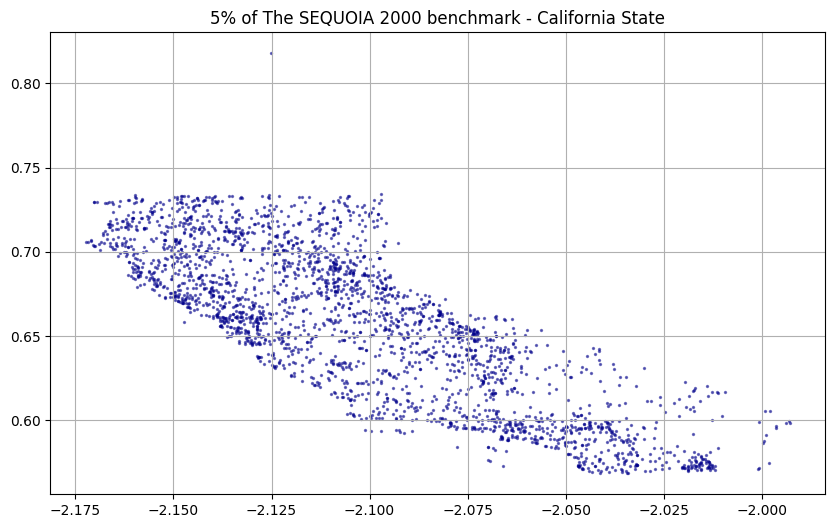

2634


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data4_5[:, 0], data4_5[:, 1], s=2, alpha=0.5, color='darkblue')
plt.title("5% of The SEQUOIA 2000 benchmark - California State")
plt.grid(True)
plt.show()
print(len(data4_5))

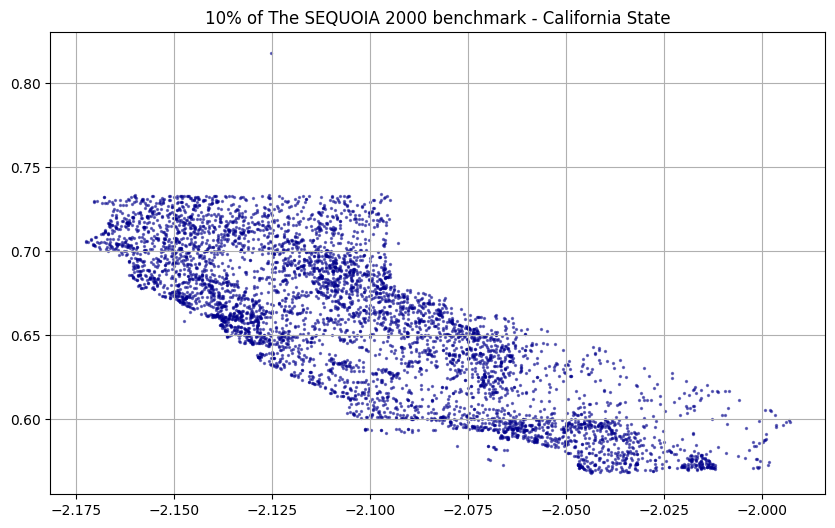

5268


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data4_10[:, 0], data4_10[:, 1], s=2, alpha=0.5, color='darkblue')
plt.title("10% of The SEQUOIA 2000 benchmark - California State")
plt.grid(True)
plt.show()
print(len(data4_10))

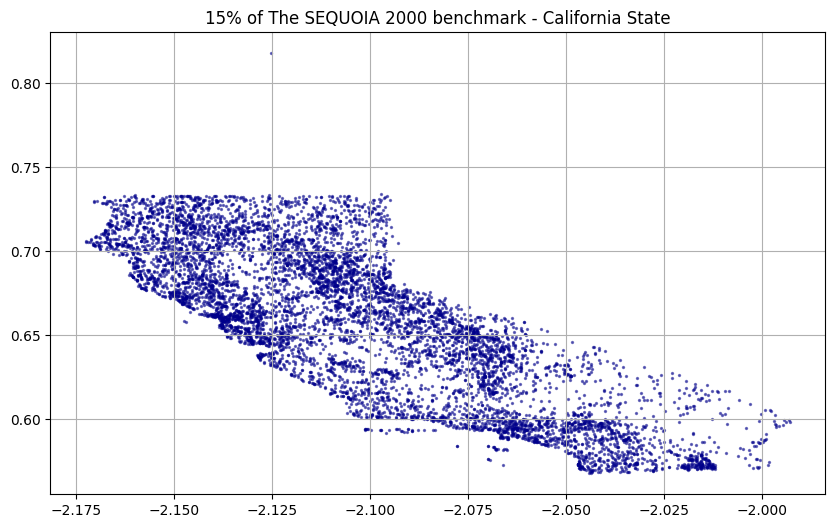

7901


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data4_15[:, 0], data4_15[:, 1], s=2, alpha=0.5, color='darkblue')
plt.title("15% of The SEQUOIA 2000 benchmark - California State")
plt.grid(True)
plt.show()
print(len(data4_15))

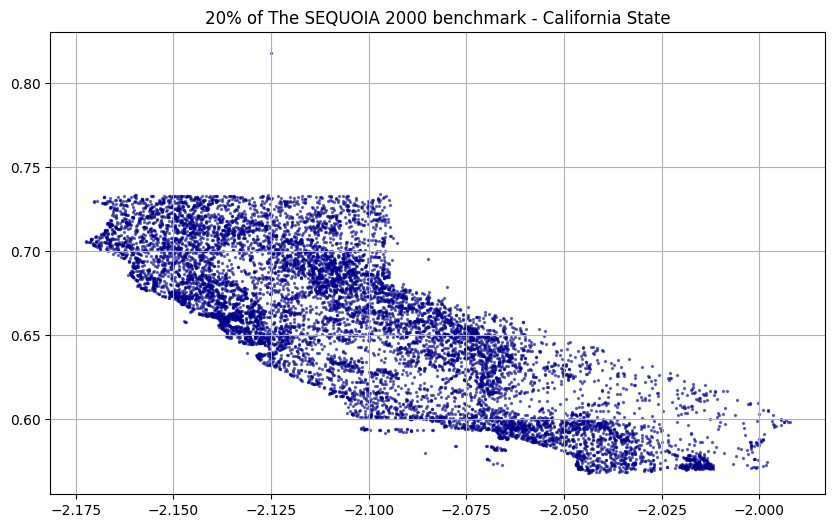

10535


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(data4_20[:, 0], data4_20[:, 1], s=2, alpha=0.5, color='darkblue')
plt.title("20% of The SEQUOIA 2000 benchmark - California State")
plt.grid(True)
plt.show()
print(len(data4_20))

Clustering with DBSCAN vs CLARANS

In [ ]:
def plot_dbscan(data, eps, title, min_samples=5, haversine=False):
    start = time.perf_counter()
    if haversine:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine')
    else:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data)
    end = time.perf_counter()

    plt.figure(figsize=(8, 6))

    cmap = plt.get_cmap('tab20')

    unique_clusters = np.unique(clusters)
    for i, label in enumerate(unique_clusters):
        mask = clusters == label
        color = 'black' if label == -1 else cmap(i % 10)
        plt.scatter(data[mask, 0], data[mask, 1], s=10, color=color, label=f"Cluster {label}" if label != -1 else "Noise")

    #plt.scatter(data[:, 0], data[:, 1], c=clusters, s=10, cmap='tab10')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.title(title)
    plt.show()
    print(len(set(clusters))) # number of clusters + 1 for noise if exists
    return end - start

def plot_clarans(data, num_clusters, title, num_local=3, maxneighbor=5):
    start = time.perf_counter()
    # Convertir en liste pour pyclustering
    data_list = data.tolist()

    # Obtenir les points initiaux via kmeans++
    initial_centers = kmeans_plusplus_initializer(data_list, num_clusters).initialize()

    # Trouver les indices des centres initiaux dans data_list
    initial_medoids = pairwise_distances_argmin(initial_centers, data_list)
    initial_medoids = initial_medoids.tolist()

    # Lancer CLARANS
    # Pass num_clusters as the second argument instead of initial_medoids
    clarans_instance = clarans(data_list, num_clusters, num_local, maxneighbor)
    clarans_instance.process()
    clusters = clarans_instance.get_clusters()

    # Créer un tableau d’étiquettes
    labels = np.full(len(data), -1)
    for cluster_id, cluster in enumerate(clusters):
        labels[cluster] = cluster_id
    end = time.perf_counter()
    # Affichage
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, s=10)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.title(title)
    plt.show()
    return end - start

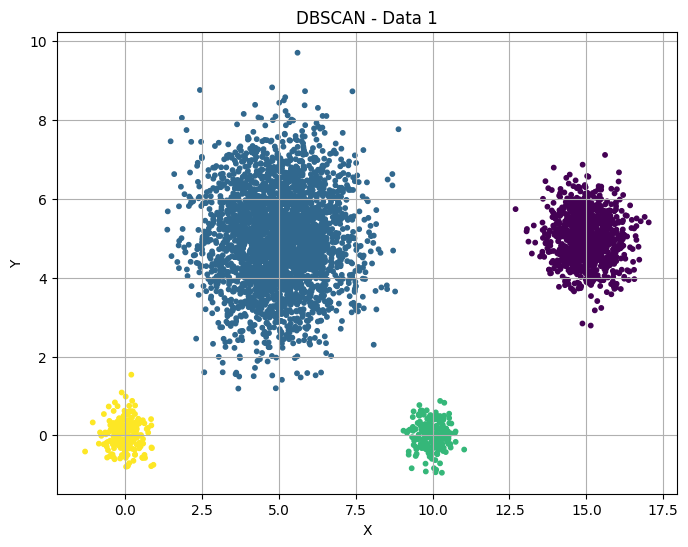

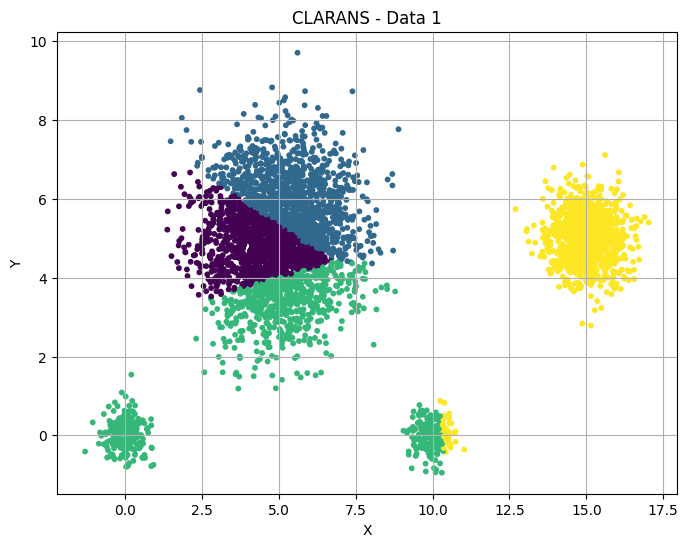

0.07247384099900955
20.402015423000194


In [ ]:
time_dbscan = plot_dbscan(data1, 1.2, "DBSCAN - Data 1", min_samples=5)
time_clarans = plot_clarans(data1, 4, "CLARANS - Data 1")

print(time_dbscan)
print(time_clarans)

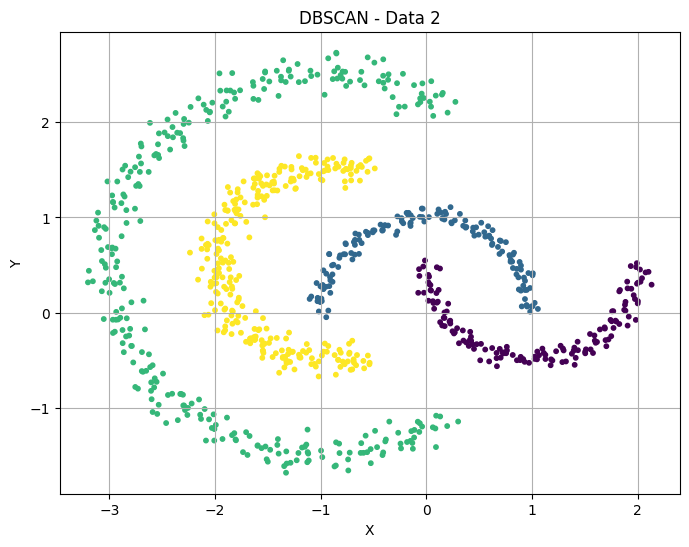

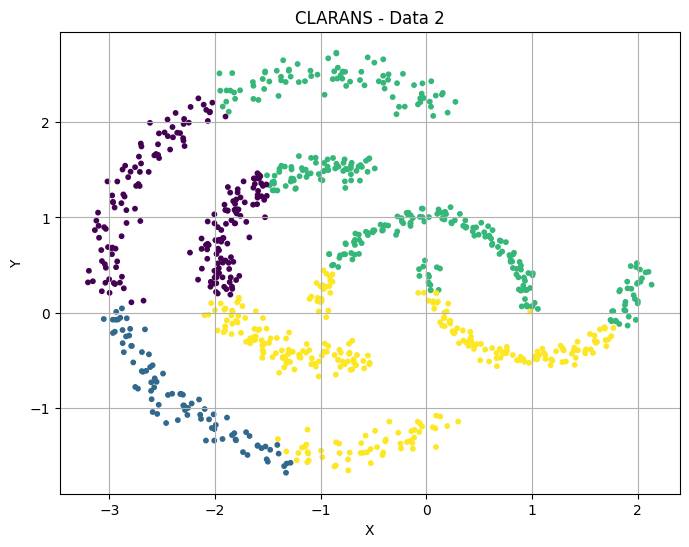

0.004945218999637291
13.200379769001302


In [ ]:
time_dbscan = plot_dbscan(data2, 0.25, "DBSCAN - Data 2", min_samples=5)
time_clarans = plot_clarans(data2, 4, "CLARANS - Data 2")

print(time_dbscan)
print(time_clarans)

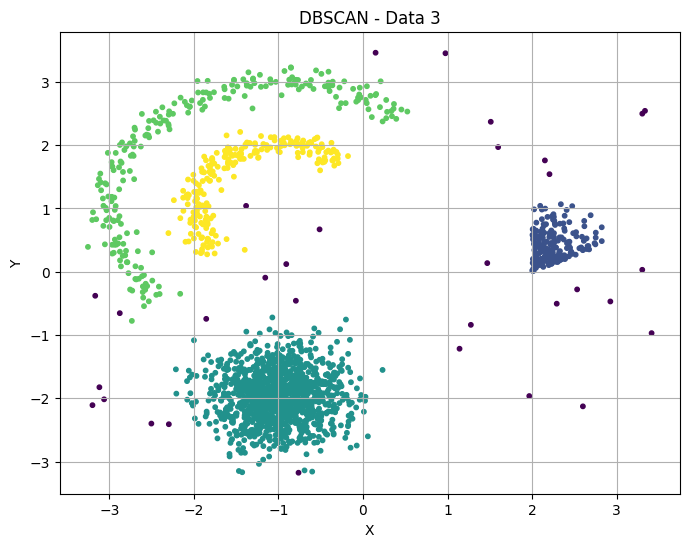

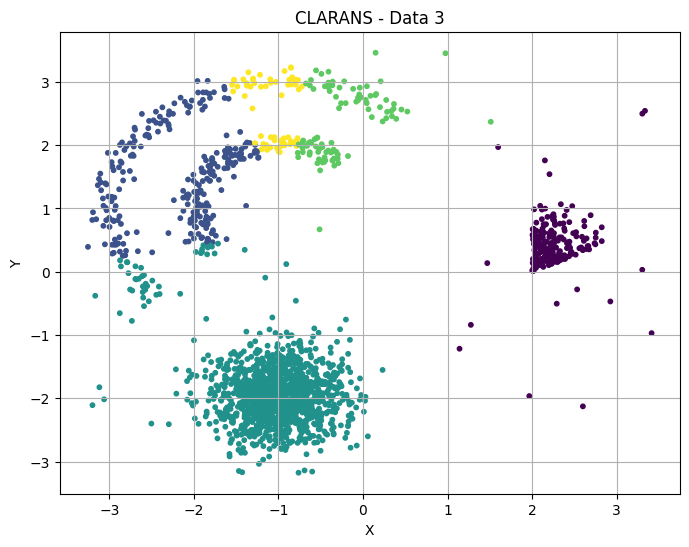

0.01397883599929628
16.951792515001216


In [ ]:
time_dbscan = plot_dbscan(data3, 0.3, "DBSCAN - Data 3", min_samples=5)
time_clarans = plot_clarans(data3, 5, "CLARANS - Data 3")

print(time_dbscan)
print(time_clarans)

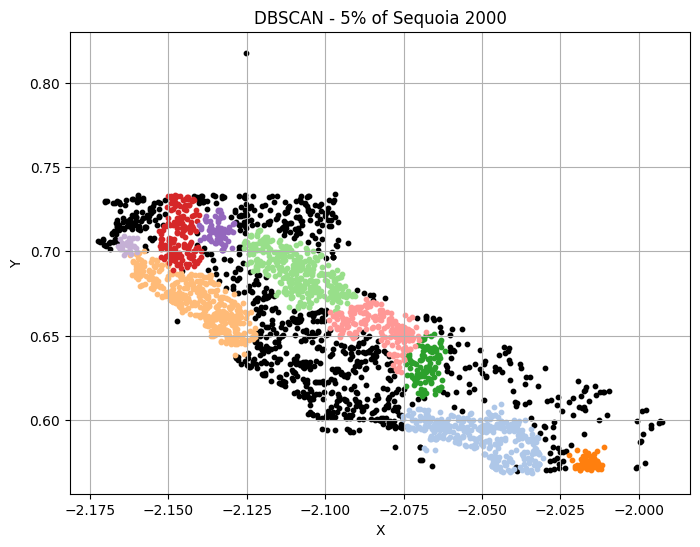

10


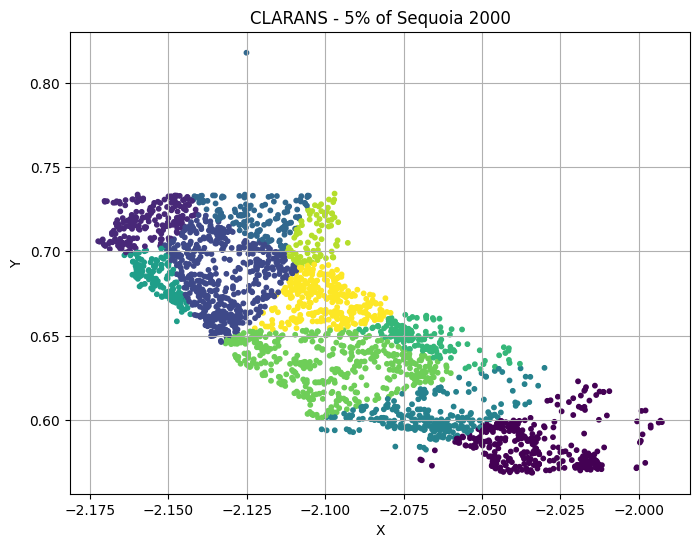

0.037967399999615736
1.9862483549986791


In [ ]:
# Choix de eps : 1000 mètre = ~0.000157 radians
eps_meters = 25000
earth_radius = 6371000  # en mètres
eps_radians = eps_meters / earth_radius

time_dbscan = plot_dbscan(data4_5, eps_radians, "DBSCAN - 5% of Sequoia 2000", min_samples=30, haversine=True)
time_clarans = plot_clarans(data4_5, 10, "CLARANS - 5% of Sequoia 2000")

print(time_dbscan)
print(time_clarans)

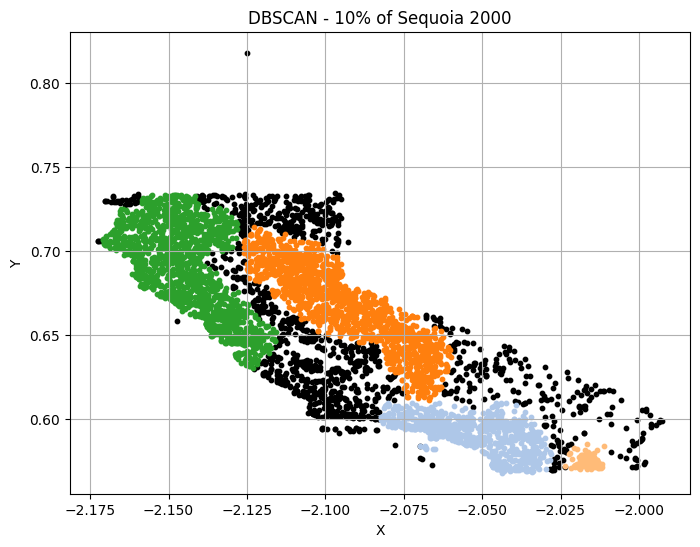

5


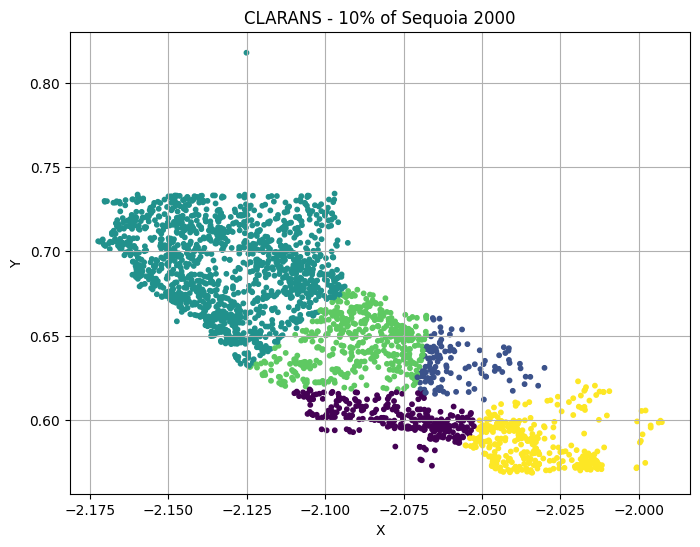

0.0933630159997847
36.27558761800174


In [ ]:
# Choix de eps : 1000 mètre = ~0.000157 radians
eps_meters = 25000
earth_radius = 6371000  # en mètres
eps_radians = eps_meters / earth_radius

time_dbscan = plot_dbscan(data4_10, eps_radians, "DBSCAN - 10% of Sequoia 2000", min_samples=50, haversine=True)
time_clarans = plot_clarans(data4_5, 5, "CLARANS - 10% of Sequoia 2000")

print(time_dbscan)
print(time_clarans)

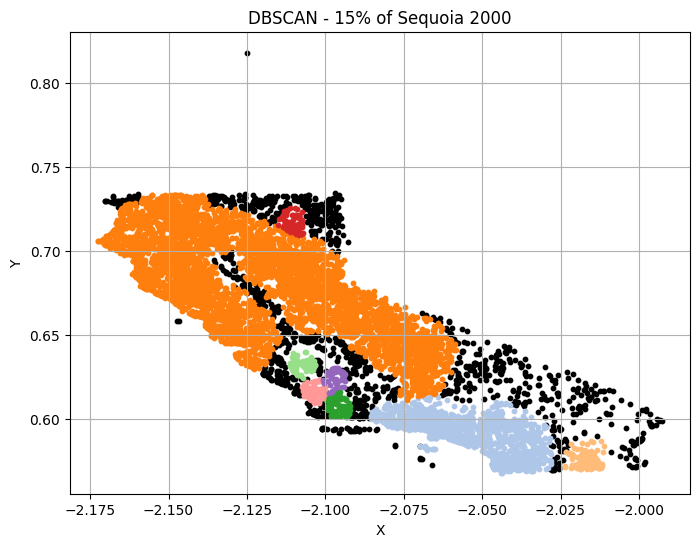

9


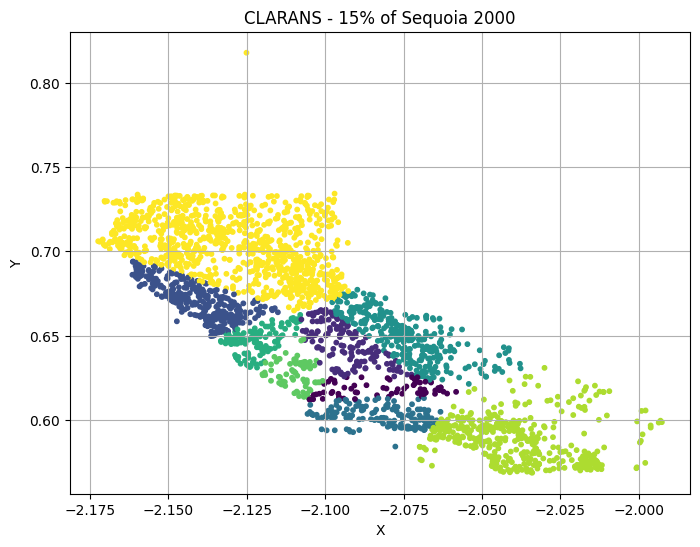

0.15371320200210903
2.563355819998833


In [ ]:
# Choix de eps : 1000 mètre = ~0.000157 radians
eps_meters = 25000
earth_radius = 6371000  # en mètres
eps_radians = eps_meters / earth_radius

time_dbscan = plot_dbscan(data4_15, eps_radians, "DBSCAN - 15% of Sequoia 2000", min_samples=65, haversine=True)
time_clarans = plot_clarans(data4_5, 9, "CLARANS - 15% of Sequoia 2000")

print(time_dbscan)
print(time_clarans)

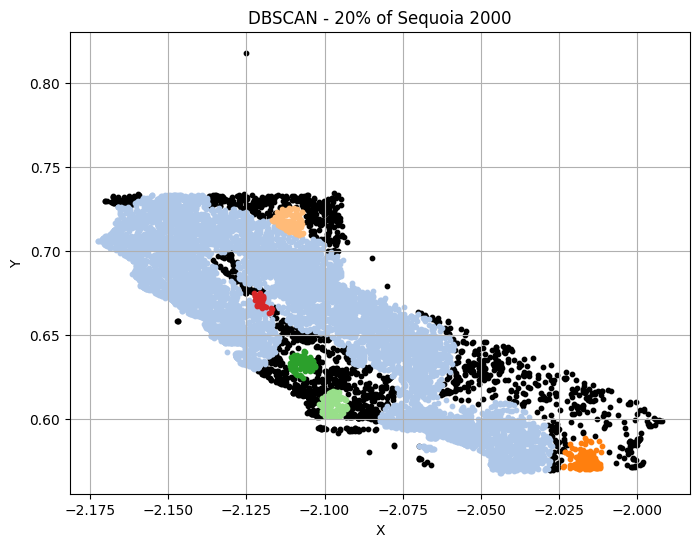

7


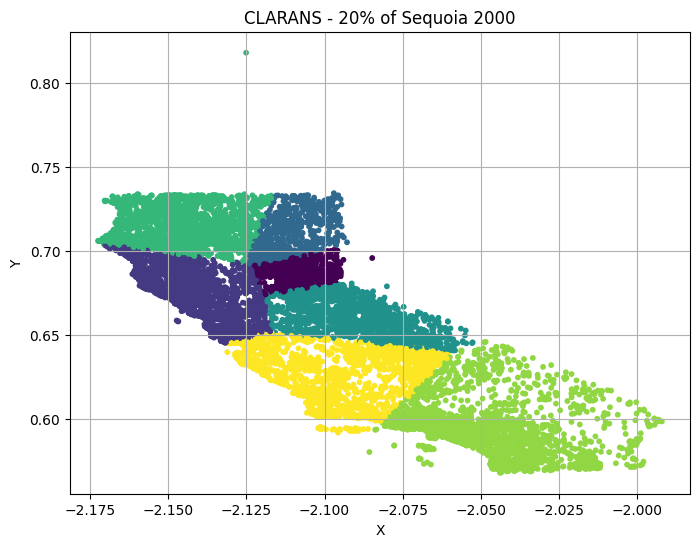

0.24165148800238967
20.452367991001665


In [ ]:
# Choix de eps : 1000 mètre = ~0.000157 radians
eps_meters = 25000
earth_radius = 6371000  # en mètres
eps_radians = eps_meters / earth_radius

time_dbscan = plot_dbscan(data4_20, eps_radians, "DBSCAN - 20% of Sequoia 2000", min_samples=85, haversine=True)
time_clarans = plot_clarans(data4_20, 7, "CLARANS - 20% of Sequoia 2000")

print(time_dbscan)
print(time_clarans)